# Imports and config

Run this first to setup the notebook.

In [2]:
# install and import
  
import os
import numpy as np
import matplotlib.pyplot as plt
import os, requests, tarfile
import pandas as pd

# Necessary for visualization
from nilearn import plotting, datasets
from nilearn.surface import vol_to_surf

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# filepaths for convinience
fpath_task = os.path.join(HCP_DIR, "hcp_task")
fpath_rest = os.path.join(HCP_DIR, "hcp_rest")

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
# def download_data():
#   """Download the HCP dataset."""

#   fnames = ["hcp_rest.tgz",
#             "hcp_task.tgz",
#             "hcp_covariates.tgz",
#             "atlas.npz"]
#   urls = ["https://osf.io/bqp7m/download",
#           "https://osf.io/s4h8j/download",
#           "https://osf.io/x5p4g/download",
#           "https://osf.io/j5kuc/download"]


#   for fname, url in zip(fnames, urls):
#     if not os.path.isfile(fname):
#       try:
#         r = requests.get(url)
#       except requests.ConnectionError:
#         print("!!! Failed to download data !!!")
#       else:
#         if r.status_code != requests.codes.ok:
#           print("!!! Failed to download data !!!")
#         else:
#           print(f"Downloading {fname}...")
#           with open(fname, "wb") as fid:
#             fid.write(r.content)
#           print(f"Download {fname} completed!")


#   fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

#   for fname in fnames:
#     # open file
#     path_name = os.path.join(HCP_DIR, fname)
#     if not os.path.exists(path_name):
#       print(f"Extracting {fname}.tgz...")
#       with tarfile.open(f"{fname}.tgz") as fzip:
#         fzip.extractall(HCP_DIR)
#     else:
#       print(f"File {fname}.tgz has already been extracted.")

In [ ]:
# download_data()

# Put functions here

If you make a couple of lines of code that does something, it's good to wrap it in a function so that it can be re-used elsewhere. Let's put all of our functions here so that the actual analysis is as clean and readable as possible. Remember to add [docstrings](https://www.datacamp.com/tutorial/docstrings-python) to your functions so we can use them without looking at source code!

In [3]:
def load_regions_and_atlas():
  """Load region info and parcellations.

    Args:
      None
    Returns:
      Tuple containing:
        region_info (dict): region names and network assignments
        atlas (dict): parcellation on the fsaverage5 surface and approximate MNI coordinates of each region
  """
  folder = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
  regions = np.load(os.path.join(folder, "regions.npy")).T
  region_info = dict(name=regions[0].tolist(),
                    network=regions[1],
                    myelin=regions[2].astype(float)
                    )
  with np.load(f"atlas.npz") as dobj:
    atlas = dict(**dobj)

  return region_info, atlas


def read_behavior_data(kind, output_type="pandas"):
    """Read behavior data from HCP dataset.

    Args:
        kind (str): "gambling", "language", "emotion", "relational", "social" or "wm",
        output_type (str): Sets the output dataframe format. Can be "numpy" or "pandas". Default is "pandas".
    Returns:
         wm_behavior (np.ndarray or pandas DataFrame): behavior data
    """
    fpath = os.path.join(HCP_DIR, "hcp", "behavior", f"{kind}.csv")

    if output_type == "numpy":
        wm_behavior = np.genfromtxt(fpath,
                                delimiter=",",
                                names=True,
                                dtype=None,
                                encoding="utf")

    elif output_type == "pandas":
        import pandas as pd
        wm_behavior = pd.read_csv(fpath)

    return wm_behavior


def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data


def seconds_to_samples(sec):
  """Converts seconds to samples (multiply by TR and floor).
  Args:
    sec (float): time in seconds
  Return:
    samples (int): time in samples
    """
  return int(sec * TR)


def get_conds(subject, task, conds, concat=False, skip=0):
    """Get timeseries for conditions of interest.
    Args:
    subject (int): subject id,
    task (string): task id ("wm", "gambling" etc.)
    conds (list): list of conditions to concatenate.
    concat (bool): If true, concatenate conditions instead of making a list.
    skip (int):  Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    Returns:
    ndarray (n_parcel x n_tp array) or list of ndarrays: Array of concatenated BOLD data values or a list of (not concatenated) data values.
    """
    # load subject timeseries
    ts = load_timeseries(subject, task, fpath_task)

    cuts = []
    # for each condition
    for cond in conds:
        # load evs
        evs = load_evs(subject, task, cond, fpath_task)

        # indexing array
        frames = condition_frames(evs, skip=skip)

        # for each run
        for run in range(len(frames)):

            # cut
            ts_cut = ts[:, frames[run]]

            # append to cuts list
            cuts.append(ts_cut)


    # Optionally concatenate in time
    if concat:
        cuts = np.concatenate(cuts, axis=-1)

    return cuts


def extract_frontoparietal_parcels(two_back, no_back, region_info):
    """
    Extracts the Frontoparietal network parcels from two_back and no_back datasets.

    Parameters:
    - two_back: List of NumPy arrays, each representing the time series data for a participant
                during the two-back task with shape (regions:360, subjects:399).
    - no_back: List of NumPy arrays, each representing the time series data for a participant
                during the no-back task with shape (regions:360, subjects:399).
    - region_info: A dictionary containing region metadata, including network assignments.

    Returns:
    - two_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                     from the two_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    - no_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                    from the no_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    """
    # Identify the indices of the 'Frontopariet' network
    fpn_network_name = "Frontopariet"
    fpn_indices = [i for i, network in enumerate(region_info['network']) if network == fpn_network_name]

    two_back_fpn = []
    no_back_fpn = []

    # Extract Frontopariet parcels for two_back
    for subject_two_back in two_back:
        frontopariet_two_back = subject_two_back[fpn_indices, :]  # Assuming subject_two_back is a numpy array
        two_back_fpn.append(frontopariet_two_back)

    # Extract Frontopariet parcels for no_back
    for subject_no_back in no_back:
        frontopariet_no_back = subject_no_back[fpn_indices, :]  # Assuming subject_no_back is a numpy array
        no_back_fpn.append(frontopariet_no_back)

    return two_back_fpn, no_back_fpn

def get_cond_onsets(num_subjects, conditions, fpath_task):
    """
    Extracts the onsets of each condition of each subject

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - Onsets: pandas dataframe containing the onset time per condition,
        separated for each run (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.))
    """
    # Initialize an empty DataFrame with NaN values
    Onsets = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)])

    # Fill the DataFrame with tuples of onset values
    for subject_id in range(num_subjects):
        for cond in conditions:
            ev =load_evs(subject_id, "wm", cond, dir=fpath_task)
            onset_values = [ev[0]['onset'],ev[1]['onset']]
            Onsets.at[f'{subject_id}', f'{cond}_run0'] = onset_values[0]
            Onsets.at[f'{subject_id}', f'{cond}_run1'] = onset_values[1]

    return Onsets

def get_cond_timeseries(num_subjects, conditions, fpath_task, Onsets):
    """
    Extracts the timeseries of each condition of each subject (360 ROI * 38 or 39 timepoints)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the timeseries of all 360 ROIs
    """
    # Initialize an empty DataFrame with NaN values
    TimeSeries = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)],columns=Onsets.columns)

    # Fill the DataFrame with tuples of timeseries values
    for subject_id in range(num_subjects):
        TS =load_timeseries(subject_id, "wm", concat=False, remove_mean=True, dir=fpath_task) # get timeseries from both runs
        for cond in conditions:
            for run in range(1):
                onset_values = [Onsets.at[f'{subject_id}', f'{cond}_run0'],Onsets.at[f'{subject_id}', f'{cond}_run1']]
                timeframe0=[int(np.floor(onset_values[0]/TR)),int(np.floor((onset_values[0]+27.5)/TR))] # 27.5 = duration in seconds
                timeframe1=[int(np.floor(onset_values[1]/TR)),int(np.floor((onset_values[1]+27.5)/TR))]
                ts_pd1=pd.DataFrame(index=[str(i) for i in range(360)], columns=[str(i) for i in range(timeframe0[1]-timeframe0[0])]) # rows=ROIs, columns=slices
                ts_pd1.iloc[:, :] = TS[0][:,timeframe0[0]:timeframe0[1]]
                ts_pd2=pd.DataFrame(index=[str(i) for i in range(360)], columns=[str(i) for i in range(timeframe1[1]-timeframe1[0])])
                ts_pd2.iloc[:, :] = TS[1][:,timeframe1[0]:timeframe1[1]]
                TimeSeries.at[f'{subject_id}', f'{cond}_run0'] = ts_pd1
                TimeSeries.at[f'{subject_id}', f'{cond}_run1'] = ts_pd2

    return TimeSeries

def get_cond_meanBOLD(num_subjects, conditions, fpath_task, TimeSeries):
    """
    Calculate the mean of BOLD intensity per subject per condition given the
        timeseries of each condition of each subject (360 ROI)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run

    Returns:
    - BOLD_MEAN: pandas dataframe containing the mean BOLD intensity per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the mean BOLD intensity of all 360 ROIs
    """
    # get mean activation from all ROIs per condition for each subject
    # Initialize an empty DataFrame with NaN values
    ROI_MEAN = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)],columns=TimeSeries.columns)
    # Fill the DataFrame with tuples of mean BOLD intensity
    for subject_id in range(num_subjects):
        print(subject_id)
        for cond in conditions:
            #print(cond)
            for run in range(2):
                ts = TimeSeries.at[f'{subject_id}', f'{cond}_run{run}'] # 360 ROIs * num_of_slices
                mean_bold=np.empty(360)
                for ROI in range(360):
                    mean_bold[ROI]=ts.iloc[ROI,:].mean()
                ROI_MEAN.at[f'{subject_id}', f'{cond}_run{run}'] = pd.Series(mean_bold)

    return ROI_MEAN

def get_cond_networkMean(num_subjects, conditions, ROI_MEAN, region_info):
  """
    Calculate the mean of BOLD intensity in each network per subject per condition given the
        mean ROI activation per condition per subject (12 Networks)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - ROI_MEAN: pandas dataframe containing the mean activation per ROI in each subject and condition
    - region_info: dictionary containing the region names and network assignments

    Returns:
    - Network_MEAN: pandas dataframe containing the mean network activation per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains a dictionary of mean ROI activation in each network
    """

  Network_MEAN = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)],columns=ROI_MEAN.columns)

  # Get the values associated with the 'network' key
  network_names = region_info['network']
  unique_network = set(network_names)

  # create an empty dictionary to store the roi indices per network
  roi_indices = {value: None for value in unique_network}

  for network_name in unique_network:
      roi_indices[network_name] = [i for i, n in enumerate(region_info['network']) if n == network_name]
      #print(f"Network: {network_name}, Indices: {roi_indices[network_name]}")

  # Fill the DataFrame with tuples of mean ROI activation per network
  for subject_id in range(num_subjects):
      print(subject_id)
      for cond in conditions:
          #print(cond)
          for run in range(2):
              #print(run)
              net_dict = {value: None for value in unique_network}
              for network_name in roi_indices.keys():
                  #print(network_name)
                  net_dict[network_name] = ROI_MEAN.at[f'{subject_id}', f'{cond}_run{run}'].iloc[roi_indices[network_name]].mean() # 360 ROIs * num_of_slices
              Network_MEAN.at[f'{subject_id}', f'{cond}_run{run}'] = net_dict

  return Network_MEAN

In [4]:
import inspect
# Get a list of all functions defined above
function_list = [name for name, obj in globals().items() if inspect.isfunction(obj)]

# Print the list of function names
for func_name in function_list:
    print(func_name)

open
Input
create_windows
vol_to_surf
load_regions_and_atlas
read_behavior_data
get_image_ids
load_timeseries
load_single_timeseries
load_evs
condition_frames
selective_average
seconds_to_samples
get_conds
extract_frontoparietal_parcels
get_cond_onsets
get_cond_timeseries
get_cond_meanBOLD
get_cond_networkMean


# Condition info

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

# Run stuff

In [5]:
# Some example functions

region_info, atlas = load_regions_and_atlas()

## Region Info & Atlas Exploratory work

In [6]:
help(load_regions_and_atlas)

Help on function load_regions_and_atlas in module __main__:

load_regions_and_atlas()
    Load region info and parcellations.

    Args:
      None
    Returns:
      Tuple containing:
        region_info (dict): region names and network assignments
        atlas (dict): parcellation on the fsaverage5 surface and approximate MNI coordinates of each region



In [7]:
region_info, atlas = load_regions_and_atlas()

**Region Info Expl. Work**

In [8]:
#make the region info a pd.data frame
region_info_pd = pd.DataFrame(region_info)
region_info_pd.head(5)

,name,network,myelin
0,R_V1,Visual1,2.20900
1,R_MST,Visual2,2.05561
2,R_V6,Visual2,2.14980
3,R_V2,Visual2,2.15347
4,R_V3,Visual2,2.07251


In [9]:
atlas

{'labels_R': array([ 54, 116,  50, ..., 134, 134, 134], dtype=int32),
 'labels_L': array([233, 228, 220, ..., 301, 301, 306], dtype=int32),
 'coords': array([[ 13.88705062, -79.36989109,   2.95539586],
        [ 43.31077929, -65.46435175,   3.65888316],
        [ 17.07818631, -76.27357601,  28.4532264 ],
        ...,
        [-43.66333418,  -6.4398113 , -15.54653597],
        [-10.61476522,  29.20779575,  26.91586381],
        [ -4.58484419,  34.61082077,  15.00143417]])}

In [10]:
#classic exploratory work
region_info_pd['network'].value_counts()


network
Posterior-Mu    77
Cingulo-Oper    56
Visual2         54
Frontopariet    50
Somatomotor     39
Language        23
Default         23
Auditory        15
Dorsal-atten     7
Visual1          6
Orbito-Affec     6
Ventral-Mult     4
Name: count, dtype: int64

**Atlas Exploratory Work**

In [11]:
#Transofrming atlas directly to a pd.DataFrame gives me an error, let's inspect why.

print(type(atlas))

for key, value in atlas.items():
  print(f"{key}: {type(value)} - {value}")

#It gives an error because it is a multidimensional array in coords.
print("atlas[\"labels_R\"].shape:", atlas["labels_L"].shape)
print("atlas[\"labels_L\"].shape:", atlas["labels_L"].shape)
print("atlas[\"coords\"].shape:", atlas["coords"].shape)

# Indeed coords has shape (360, 3). Let's unpack it to transofrm it into a pd.DataFrame for comodity later.
# Probably coords corresponds to coordinates, and the fact that it has three dimensions means x, y, z.
# So let's unpack it into these three.

coords = pd.DataFrame(atlas['coords'], columns=['x', 'y', 'z'])

#Let's also create two DataFrames for the other labels

labels = pd.DataFrame({
    'labels_R': atlas['labels_R'],
    'labels_L': atlas['labels_L']
})

# Let's then concatenate and form a final pd.DataFrame

atlas_pd = pd.concat([labels, coords], axis=1)

atlas_pd.describe()

<class 'dict'>
labels_R: <class 'numpy.ndarray'> - [ 54 116  50 ... 134 134 134]
labels_L: <class 'numpy.ndarray'> - [233 228 220 ... 301 301 306]
coords: <class 'numpy.ndarray'> - [[ 13.88705062 -79.36989109   2.95539586]
 [ 43.31077929 -65.46435175   3.65888316]
 [ 17.07818631 -76.27357601  28.4532264 ]
 ...
 [-43.66333418  -6.4398113  -15.54653597]
 [-10.61476522  29.20779575  26.91586381]
 [ -4.58484419  34.61082077  15.00143417]]
atlas["labels_R"].shape: (10242,)
atlas["labels_L"].shape: (10242,)
atlas["coords"].shape: (360, 3)


,labels_R,labels_L,x,y,z
count,10242.000000,10242.000000,360.000000,360.000000,360.000000
mean,74.895723,239.905292,0.232971,-19.138973,15.676536
std,55.650470,89.207969,35.276493,39.695339,25.627438
min,-1.000000,-1.000000,-62.865576,-89.084417,-41.542674
25%,24.000000,203.000000,-32.730772,-52.996699,-6.106534
50%,71.000000,252.000000,0.205165,-21.611199,14.244696
75%,127.000000,306.000000,33.294983,13.148663,37.123880
max,179.000000,359.000000,64.164492,63.032918,69.800713


## Working Memory Task exploratory work

In [12]:
help(read_behavior_data)

Help on function read_behavior_data in module __main__:

read_behavior_data(kind, output_type='pandas')
    Read behavior data from HCP dataset.

    Args:
        kind (str): "gambling", "language", "emotion", "relational", "social" or "wm",
        output_type (str): Sets the output dataframe format. Can be "numpy" or "pandas". Default is "pandas".
    Returns:
         wm_behavior (np.ndarray or pandas DataFrame): behavior data



In [13]:
wm_behavior = read_behavior_data("wm")
print(type(wm_behavior))

<class 'pandas.core.frame.DataFrame'>


In [14]:
wm_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5382 entries, 0 to 5381
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Subject              5382 non-null   int64  
 1   Run                  5382 non-null   int64  
 2   ConditionName        5382 non-null   object 
 3   ACC                  5382 non-null   float64
 4   ACC_NONTARGET        5376 non-null   float64
 5   ACC_TARGET           5382 non-null   float64
 6   MEDIAN_RT            5376 non-null   float64
 7   MEDIAN_RT_NONTARGET  5373 non-null   float64
 8   MEDIAN_RT_TARGET     4894 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 378.6+ KB


In [15]:
wm_behavior.describe()

,Subject,Run,ACC,ACC_NONTARGET,ACC_TARGET,MEDIAN_RT,MEDIAN_RT_NONTARGET,MEDIAN_RT_TARGET
count,5382.000000,5382.000000,5382.000000,5376.000000,5382.000000,5376.000000,5373.000000,4894.000000
mean,168.880342,0.500000,0.887769,0.910280,0.809365,861.748326,869.721292,872.043318
std,97.799125,0.500046,0.152766,0.143950,0.322284,241.638974,254.814939,276.054963
min,0.000000,0.000000,0.100000,0.000000,0.000000,291.000000,291.000000,75.000000
25%,84.250000,0.000000,0.800000,0.833333,0.500000,676.000000,675.000000,665.500000
50%,169.000000,0.500000,1.000000,1.000000,1.000000,821.500000,828.500000,815.000000
75%,253.750000,1.000000,1.000000,1.000000,1.000000,1005.500000,1023.500000,1023.500000
max,338.000000,1.000000,1.000000,1.000000,1.000000,1839.000000,1839.000000,1978.000000


In [16]:
wm_behavior.head(15)

,Subject,Run,ConditionName,ACC,ACC_NONTARGET,ACC_TARGET,MEDIAN_RT,MEDIAN_RT_NONTARGET,MEDIAN_RT_TARGET
0,0,0,0BK_BODY,1.00,1.000000,1.0,705.5,740.5,696.0
1,0,0,0BK_FACE,1.00,1.000000,1.0,779.5,765.0,915.0
2,0,0,0BK_PLACE,1.00,1.000000,1.0,926.0,993.5,811.5
3,0,0,0BK_TOOL,1.00,1.000000,1.0,807.5,807.5,807.5
4,0,0,2BK_BODY,1.00,1.000000,1.0,1133.0,1205.5,732.5
5,0,0,2BK_FACE,1.00,1.000000,1.0,1308.5,1350.5,1064.5
6,0,0,2BK_PLACE,1.00,1.000000,1.0,1016.0,1016.0,1097.0
7,0,0,2BK_TOOL,0.75,0.666667,1.0,892.0,892.0,915.5
8,0,1,0BK_BODY,1.00,1.000000,1.0,1117.0,1117.0,1350.0
9,0,1,0BK_FACE,1.00,1.000000,1.0,806.5,806.5,755.5


## Times series exploratory Work

In [17]:
print(function_list)

['open', 'Input', 'create_windows', 'vol_to_surf', 'load_regions_and_atlas', 'read_behavior_data', 'get_image_ids', 'load_timeseries', 'load_single_timeseries', 'load_evs', 'condition_frames', 'selective_average', 'seconds_to_samples', 'get_conds', 'extract_frontoparietal_parcels', 'get_cond_onsets', 'get_cond_timeseries', 'get_cond_meanBOLD', 'get_cond_networkMean']


In [18]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.

    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean

    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [19]:
help(load_single_timeseries)

Help on function load_single_timeseries in module __main__:

load_single_timeseries(subject, bold_run, dir, remove_mean=True)
    Load timeseries data for a single subject and single run.

    Args:
      subject (int): 0-based subject ID to load
      bold_run (int): 1-based run index, across all tasks
      dir (str) : data directory
      remove_mean (bool): If True, subtract the parcel-wise mean

    Returns
      ts (n_parcel x n_timepoint array): Array of BOLD data values



In [20]:
ts0 = load_timeseries(0, "wm", fpath_task)

print('type(ts0):', type(ts0))
print('ts0.shape:', ts0.shape)
print('Number of elements in ts0:', ts0.size)
print('ts0.dtype:', ts0.dtype)
print(ts0)

type(ts0): <class 'numpy.ndarray'>
ts0.shape: (360, 810)
Number of elements in ts0: 291600
ts0.dtype: float64
[[ -16.91901235  -53.11901235  -54.61901235 ...  -82.17975309
   -77.37975309  -89.27975309]
 [  63.30716049   26.30716049   45.30716049 ...  -46.91111111
     6.98888889  -20.51111111]
 [ 175.83382716   72.73382716   65.23382716 ...  -43.18666667
   -57.88666667  -90.68666667]
 ...
 [ 137.83901235   59.63901235   53.93901235 ...   18.26518519
    13.36518519  -37.43481481]
 [  53.99753086  -16.20246914  -79.10246914 ... -105.61259259
   -96.41259259  -99.71259259]
 [ -86.74691358 -113.34691358 -129.44691358 ...    5.38666667
    23.58666667  -23.41333333]]


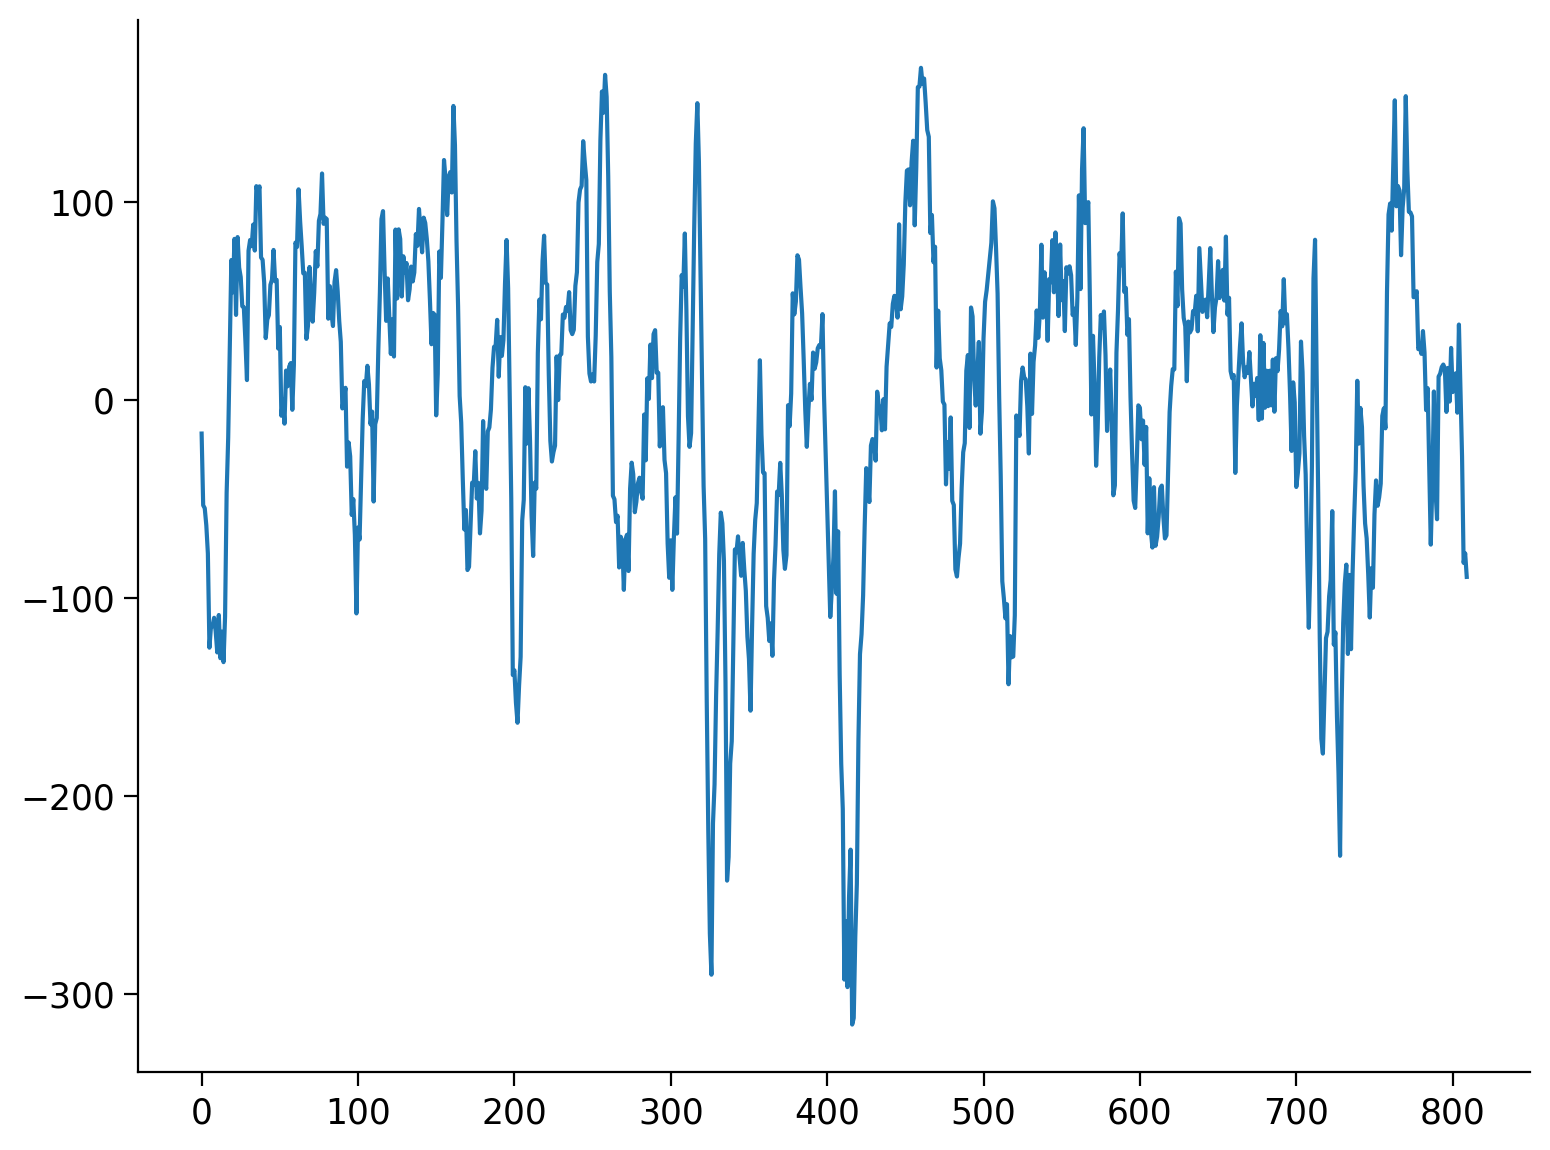

In [21]:
plt.plot(ts0[0, :])

In [22]:
# curious about a fun? use help()
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.

    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean

    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



## Concatenate conditions

This can be used to concatenate any number of conditions within any task. Just provide a list of all conditions you wanna concat and task id.

In [23]:
help(get_conds)

Help on function get_conds in module __main__:

get_conds(subject, task, conds, concat=False, skip=0)
    Get timeseries for conditions of interest.
    Args:
    subject (int): subject id,
    task (string): task id ("wm", "gambling" etc.)
    conds (list): list of conditions to concatenate.
    concat (bool): If true, concatenate conditions instead of making a list.
    skip (int):  Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    Returns:
    ndarray (n_parcel x n_tp array) or list of ndarrays: Array of concatenated BOLD data values or a list of (not concatenated) data values.



In [24]:
# list all 2-back conditions
two_back_conds = ['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']

# list all 0-back conditions
no_back_conds = ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools']

two_back, no_back = [], []
for s in subjects:
  two_back.append(get_conds(s, "wm", two_back_conds, concat=True))
  no_back.append(get_conds(s, "wm", no_back_conds, concat=True))

print(two_back[0].shape)

(360, 312)


## Extract FPN timeseries

In [25]:
## Use the extract_frontoparietal_parcels function
help(extract_frontoparietal_parcels)

Help on function extract_frontoparietal_parcels in module __main__:

extract_frontoparietal_parcels(two_back, no_back, region_info)
    Extracts the Frontoparietal network parcels from two_back and no_back datasets.

    Parameters:
    - two_back: List of NumPy arrays, each representing the time series data for a participant
                during the two-back task with shape (regions:360, subjects:399).
    - no_back: List of NumPy arrays, each representing the time series data for a participant
                during the no-back task with shape (regions:360, subjects:399).
    - region_info: A dictionary containing region metadata, including network assignments.

    Returns:
    - two_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                     from the two_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    - no_back_fpn: List of NumPy arrays containing only the Frontoparietal network parcels
                    from the no_back

In [26]:
## Uses the extract_frontoparietal_parcels to extract timeseries of parcels belonging to FPN
two_back_fpn, no_back_fpn = extract_frontoparietal_parcels(two_back, no_back, region_info)

## Data Cleaning, slicing etc

Subjects whom did not 16 trials:
 Subject

*   329
*   143
*   81

You get two datset for evs:
* evs_0bk_mean (336, 5)
* evs_2bk_mean (336, 5)

And two for wm_behavior

* wm_beh_0bk_mean (336, 9)
* wm_beh_2bk_mean (336, 9)

In [27]:
#Subjects who didn't finish the whole task

# Step 1: Count the occurrences of each Subject
subject_counts = wm_behavior['Subject'].value_counts()

# Step 2: Mask to identify subjects that do not appear exactly 16 times
subjects_not_16_mask = subject_counts != 16

# Step 3: Apply the mask to get subjects not appearing 16 times
subjects_not_16 = subject_counts[subjects_not_16_mask]

# Step 4: Print these subjects with their counts
print('Subjects whom did not 16 trials:\n', subjects_not_16)

Subjects whom did not 16 trials:
 Subject
329    2
143    2
81     2
Name: count, dtype: int64


In [28]:
#Load evs data for all the conditions

conds =  ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools','2bk_body', '2bk_faces', '2bk_places', '2bk_tools']

evs_data = []

for i in range(339):
  for x in conds:
    evs = load_evs(i, 'wm', x, fpath_task)
    evs_df = pd.DataFrame(evs)
    evs_df['Subject'] = i
    evs_df['Condition'] = x
    evs_data.append(evs_df)

evs_data = pd.concat(evs_data, ignore_index=True)

print(type(evs_data))
print(len(evs_data))
print(evs_data.shape)
evs_data.head(10)



<class 'pandas.core.frame.DataFrame'>
5424
(5424, 5)


,onset,duration,amplitude,Subject,Condition
0,[107.463],[27.5],[1.0],0,0bk_body
1,[36.146],[27.5],[1.0],0,0bk_body
2,[36.159],[27.5],[1.0],0,0bk_faces
3,[222.057],[27.5],[1.0],0,0bk_faces
4,[150.579],[27.5],[1.0],0,0bk_places
5,[250.339],[27.5],[1.0],0,0bk_places
6,[222.057],[27.5],[1.0],0,0bk_tools
7,[107.503],[27.5],[1.0],0,0bk_tools
8,[7.997],[27.5],[1.0],0,2bk_body
9,[150.593],[27.5],[1.0],0,2bk_body


In [29]:
#Something is off.
# Count the occurrences of each Subject
subject_counts_e = evs_data['Subject'].value_counts()
print(subject_counts_e[0])

# Mask to identify subjects that do not appear exactly 16 times
subjects_not_16_mask_e = subject_counts != 16

# Apply the mask to get subjects not appearing 16 times
subjects_not_16_e = subject_counts[subjects_not_16_mask]

# Print these subjects with their counts
print('Subjects whom did not 16 trials:\n', subjects_not_16_e)

16
Subjects whom did not 16 trials:
 Subject
329    2
143    2
81     2
Name: count, dtype: int64


In [30]:
# Take off these subjects from evs_data

# Get the list of subjects to be excluded
subjects_not_16_e = subject_counts[subjects_not_16_mask].index
print(subjects_not_16_e)

# Create a mask to exclude these subjects from the DataFrame
exclude_mask_e = ~evs_data['Subject'].isin(subjects_not_16_e)

# Apply the mask to the DataFrame to filter out these subjects
evs_data_filtered = evs_data[exclude_mask_e]

print(evs_data_filtered .shape)
print(type(evs_data_filtered))
evs_data_filtered.head(10)

# Let's now divide the dataset in 0bk and 2bk

# Create boolean masks for 0bk and 2bk conditions
mask_0bk = evs_data_filtered['Condition'].str.contains('0bk', case=False)
mask_2bk = evs_data_filtered['Condition'].str.contains('2bk', case=False)

#  Create separate DataFrames for 0bk and 2bk
evs_0bk = evs_data_filtered[mask_0bk].copy()
evs_2bk = evs_data_filtered[mask_2bk].copy()

# Display the shapes of the new DataFrames
print("Shape of evs_0bk:", evs_0bk.shape)
print("Shape of evs_2bk:", evs_2bk.shape)

print("\nFirst few rows of evs_0bk:")
print(evs_0bk.head())

print("\nFirst few rows of evs_2bk:")
print(evs_2bk.head())

# Now let's get the mean

columns = ['Subject', 'Condition', 'onset', 'duration', 'amplitude']

evs_0bk_mean = pd.DataFrame(columns)

# Group by Subject and aggregate to find mean onset, duration, and amplitude
evs_0bk_mean = evs_0bk.groupby('Subject').agg({
    'onset': lambda x: np.mean(x),
    'duration': lambda x: np.mean(x),
    'amplitude': lambda x: np.mean(x),
}).reset_index()

# Set Condition to '0bk' for all rows
evs_0bk_mean['Condition'] = '0bk'

# Print first few rows of evs_0bk_mean
print(evs_0bk_mean.head())
print(evs_0bk_mean.shape)


evs_2bk_mean = pd.DataFrame(columns=columns)

# Filter for 2bk conditions in evs_data_filtered
mask_2bk = evs_data_filtered['Condition'].str.contains('2bk', case=False)
evs_2bk = evs_data_filtered[mask_2bk].copy()

# Group by Subject and aggregate to find mean onset, duration, and amplitude
evs_2bk_mean = evs_2bk.groupby('Subject').agg({
    'onset': lambda x: np.mean(x),
    'duration': lambda x: np.mean(x),
    'amplitude': lambda x: np.mean(x),
}).reset_index()

# Set Condition to '2bk' for all rows
evs_2bk_mean['Condition'] = '2bk'

# Print first few rows of evs_2bk_mean
print(evs_2bk_mean.head())
print(evs_2bk_mean.shape)

Index([329, 143, 81], dtype='int64', name='Subject')
(5376, 5)
<class 'pandas.core.frame.DataFrame'>
Shape of evs_0bk: (2688, 5)
Shape of evs_2bk: (2688, 5)

First few rows of evs_0bk:
       onset duration amplitude  Subject   Condition
0  [107.463]   [27.5]     [1.0]        0    0bk_body
1   [36.146]   [27.5]     [1.0]        0    0bk_body
2   [36.159]   [27.5]     [1.0]        0   0bk_faces
3  [222.057]   [27.5]     [1.0]        0   0bk_faces
4  [150.579]   [27.5]     [1.0]        0  0bk_places

First few rows of evs_2bk:
        onset duration amplitude  Subject   Condition
8     [7.997]   [27.5]     [1.0]        0    2bk_body
9   [150.593]   [27.5]     [1.0]        0    2bk_body
10  [178.794]   [27.5]     [1.0]        0   2bk_faces
11   [79.275]   [27.5]     [1.0]        0   2bk_faces
12  [250.219]   [27.5]     [1.0]        0  2bk_places
   Subject                 onset duration amplitude Condition
0        0  [141.53787499999999]   [27.5]     [1.0]       0bk
1        1          [

In [31]:
# Let's do the same filtering, splitting and mean getting for the behavior

In [32]:
#  Get the list of subjects to be excluded
subjects_not_16 = subject_counts[subjects_not_16_mask].index

# Create a mask to exclude these subjects from the DataFrame
exclude_mask = ~wm_behavior['Subject'].isin(subjects_not_16)

#  Apply the mask to the DataFrame to filter out these subjects
filtered_wm_behavior = wm_behavior[exclude_mask]

print(filtered_wm_behavior.shape)
print(type(filtered_wm_behavior))
filtered_wm_behavior.head(10)


#  Create boolean masks for 0bk and 2bk conditions in filtered_wm_behavior
mask_0bk = filtered_wm_behavior['ConditionName'].str.contains('0bk', case=False)
mask_2bk = filtered_wm_behavior['ConditionName'].str.contains('2bk', case=False)

#  Create separate DataFrames for 0bk and 2bk in filtered_wm_behavior
wm_beh_0bk = filtered_wm_behavior[mask_0bk].copy()
wm_beh_2bk = filtered_wm_behavior[mask_2bk].copy()

# Display the shapes of the new DataFrames
print("Shape wm_beh_0bk:", wm_beh_0bk.shape)
print("Shape wm_beh_2bk:", wm_beh_2bk.shape)

print("\nFirst few rows wm_beh_0bk:")
print(wm_beh_0bk.head())

print("\nFirst few rows wm_beh_2bk:")
print(wm_beh_2bk.head())


# Get the means

columns = ['Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET']

# Initialize a DataFrame with the specified columns
wm_beh_0bk_mean = pd.DataFrame(columns=columns)

# Group by Subject and aggregate to find mean ACC, MEDIAN_RT, etc.
wm_beh_0bk_mean = filtered_wm_behavior.groupby('Subject').agg({
    'Run': 'mean',
    'ACC': 'mean',
    'ACC_NONTARGET': 'mean',
    'ACC_TARGET': 'mean',
    'MEDIAN_RT': 'mean',
    'MEDIAN_RT_NONTARGET': 'mean',
    'MEDIAN_RT_TARGET': 'mean'
}).reset_index()

# Set ConditionName to '0bk' for all rows
wm_beh_0bk_mean['ConditionName'] = '0bk'

# Reorder columns to match the original DataFrame structure
wm_beh_0bk_mean = wm_beh_0bk_mean[columns]

# Print first few rows of wm_beh_0bk_mean
print(wm_beh_0bk_mean.head())
print(wm_beh_0bk_mean.shape)


# Initialize a DataFrame with the specified columns
wm_beh_2bk_mean = pd.DataFrame(columns=columns)

# Group by Subject and aggregate to find mean ACC, MEDIAN_RT, etc.
wm_beh_2bk_mean = wm_beh_2bk.groupby('Subject').agg({
    'Run': 'mean',
    'ACC': 'mean',
    'ACC_NONTARGET': 'mean',
    'ACC_TARGET': 'mean',
    'MEDIAN_RT': 'mean',
    'MEDIAN_RT_NONTARGET': 'mean',
    'MEDIAN_RT_TARGET': 'mean'
}).reset_index()

# Set ConditionName to '2bk' for all rows
wm_beh_2bk_mean['ConditionName'] = '2bk'

# Reorder columns to match the original DataFrame structure
wm_beh_2bk_mean = wm_beh_2bk_mean[columns]

# Print first few rows of wm_beh_2bk_mean
print(wm_beh_2bk_mean.head())
print(wm_beh_2bk_mean.shape)

(5376, 9)
<class 'pandas.core.frame.DataFrame'>
Shape wm_beh_0bk: (2688, 9)
Shape wm_beh_2bk: (2688, 9)

First few rows wm_beh_0bk:
   Subject  Run ConditionName  ACC  ACC_NONTARGET  ACC_TARGET  MEDIAN_RT  \
0        0    0      0BK_BODY  1.0            1.0         1.0      705.5   
1        0    0      0BK_FACE  1.0            1.0         1.0      779.5   
2        0    0     0BK_PLACE  1.0            1.0         1.0      926.0   
3        0    0      0BK_TOOL  1.0            1.0         1.0      807.5   
8        0    1      0BK_BODY  1.0            1.0         1.0     1117.0   

   MEDIAN_RT_NONTARGET  MEDIAN_RT_TARGET  
0                740.5             696.0  
1                765.0             915.0  
2                993.5             811.5  
3                807.5             807.5  
8               1117.0            1350.0  

First few rows wm_beh_2bk:
    Subject  Run ConditionName   ACC  ACC_NONTARGET  ACC_TARGET  MEDIAN_RT  \
4         0    0      2BK_BODY  1.00       1.00

Plotting

## BOLD mean intensity
To run the function in this section you need to first run the *get_cond_onsets()* and *get_cond_timeseries()* from the **Section: Get condition onsets & timeseries**

### Get event onsets

In [33]:
help(get_cond_onsets)

Help on function get_cond_onsets in module __main__:

get_cond_onsets(num_subjects, conditions, fpath_task)
    Extracts the onsets of each condition of each subject

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - Onsets: pandas dataframe containing the onset time per condition,
        separated for each run (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.))



In [34]:
# Get condition onsets
conditions=['2bk_body', '2bk_faces', '2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
num_subjects = 339

Onsets = get_cond_onsets(num_subjects,conditions,fpath_task)

print(Onsets.head())

   2bk_body_run0  2bk_body_run1  2bk_faces_run0  2bk_faces_run1  \
0          7.997        150.593         178.794          79.275   
1          7.996        150.806         179.021          79.355   
2          7.997        150.538         178.767          79.234   
3          7.997        150.514         178.783          79.209   
4          7.997        150.966         179.141          79.434   

   2bk_places_run0  2bk_places_run1  2bk_tools_run0  2bk_tools_run1  \
0          250.219          178.755          79.368           7.997   
1          250.499          178.968          79.434           7.997   
2          250.071          178.646          79.368           7.997   
3          250.088          178.596          79.369           7.997   
4          250.712          179.141          79.488           7.997   

   0bk_body_run0  0bk_body_run1  0bk_faces_run0  0bk_faces_run1  \
0        107.463         36.146          36.159         222.057   
1        107.650         36.226     

### Get event timeseries

In [35]:
help(get_cond_timeseries)

Help on function get_cond_timeseries in module __main__:

get_cond_timeseries(num_subjects, conditions, fpath_task, Onsets)
    Extracts the timeseries of each condition of each subject (360 ROI * 38 or 39 timepoints)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the timeseries of all 360 ROIs



In [36]:
# Get events timeseries
conditions=['2bk_body', '2bk_faces', '2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
num_subjects = 339
TimeSeries = get_cond_timeseries(num_subjects,conditions,fpath_task,Onsets)

print(TimeSeries.shape) # 339 * 16
print(TimeSeries.index) # rows=339 subjects
print(TimeSeries.columns) # columns=8 conditions in 2 runs
print(TimeSeries.iloc[0,0]) # 360 ROIs * (38 or 39) slices

(339, 16)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '329', '330', '331', '332', '333', '334', '335', '336', '337', '338'],
      dtype='object', length=339)
Index(['2bk_body_run0', '2bk_body_run1', '2bk_faces_run0', '2bk_faces_run1',
       '2bk_places_run0', '2bk_places_run1', '2bk_tools_run0',
       '2bk_tools_run1', '0bk_body_run0', '0bk_body_run1', '0bk_faces_run0',
       '0bk_faces_run1', '0bk_places_run0', '0bk_places_run1',
       '0bk_tools_run0', '0bk_tools_run1'],
      dtype='object')
              0           1           2           3           4           5  \
0   -108.519012 -130.319012 -116.919012 -132.319012 -109.219012  -46.819012   
1     113.20716    69.80716   125.60716   126.00716   142.40716    47.40716   
2     49.633827   58.733827   21.133827    0.333827   -1.166173   84.333827   
3    -56.068395  -54.068395  -22.168395  -63.668395  -67.568395  -38.068395   
4    -51.088148  -77.288148  -37.788148  -53.788148  -79.688148  -33.

### mean ROI activation (339 sub * 16 blk * 360 ROI)

In [37]:
help(get_cond_meanBOLD)

Help on function get_cond_meanBOLD in module __main__:

get_cond_meanBOLD(num_subjects, conditions, fpath_task, TimeSeries)
    Calculate the mean of BOLD intensity per subject per condition given the
        timeseries of each condition of each subject (360 ROI)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run

    Returns:
    - BOLD_MEAN: pandas dataframe containing the mean BOLD intensity per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the mean BOLD intensity of all 360 ROIs



In [38]:
# get mean activation of all ROIs per blocks for each subject
# Note: this function may take a few minutes to run
ROI_MEAN = get_cond_meanBOLD(num_subjects,conditions,fpath_task,TimeSeries)

#print(BOLD_MEAN.shape) # 360 (ROI) * 16 (blocks)
#print(BOLD_MEAN.iloc[156,7].size) # pd.Series of size 360 (ROI)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### mean Network activation (339 sub * 16 blk * 12 Nets)

In [39]:
help(get_cond_networkMean)

Help on function get_cond_networkMean in module __main__:

get_cond_networkMean(num_subjects, conditions, ROI_MEAN, region_info)
    Calculate the mean of BOLD intensity in each network per subject per condition given the
        mean ROI activation per condition per subject (12 Networks)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - ROI_MEAN: pandas dataframe containing the mean activation per ROI in each subject and condition
    - region_info: dictionary containing the region names and network assignments

    Returns:
    - Network_MEAN: pandas dataframe containing the mean network activation per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd 

In [40]:
# get mean activation from all Networks (mean of ROIs in network) per condition for each subject
conditions=['2bk_body', '2bk_faces', '2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
num_subjects = 339

Network_MEAN = get_cond_networkMean(num_subjects, conditions, ROI_MEAN, region_info)

print(Network_MEAN.shape)
print(Network_MEAN.loc['225','2bk_faces_run1'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Expected window length: 20
two_back_fpn shape: (50, 312)
no_back_fpn shape: (50, 312)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_windows shape: (74, 50, 20)
Generated two_back_wi

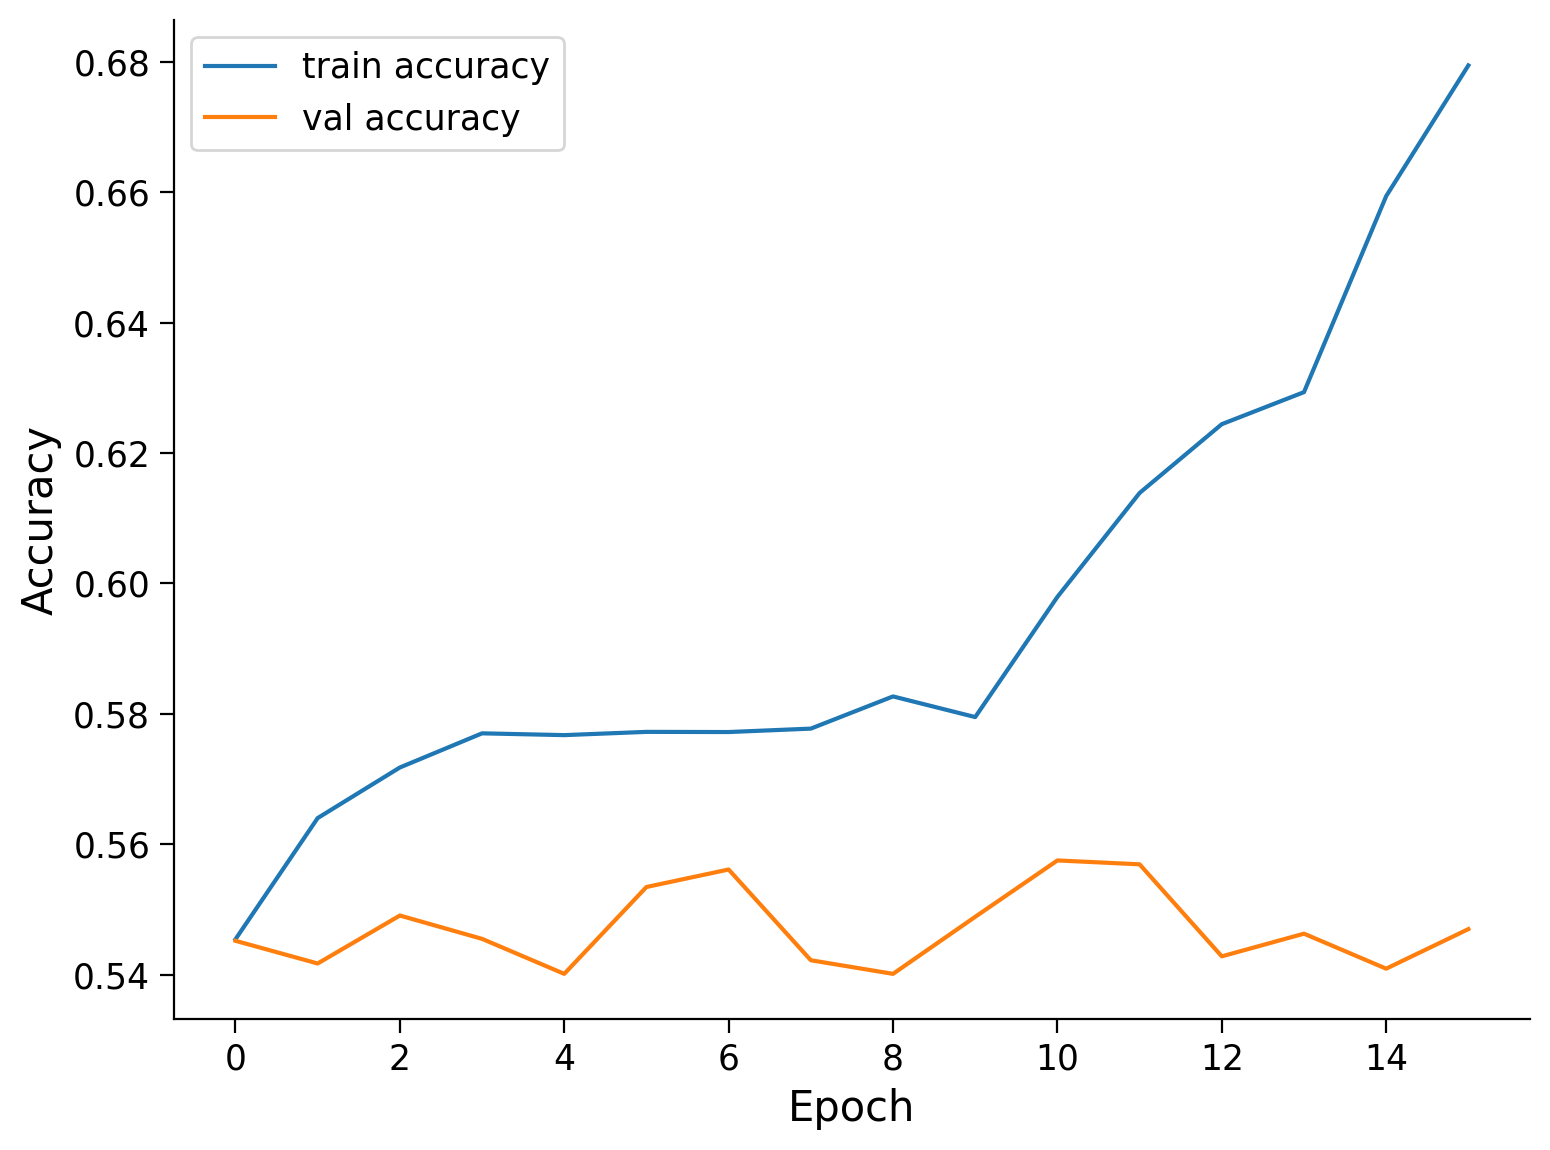

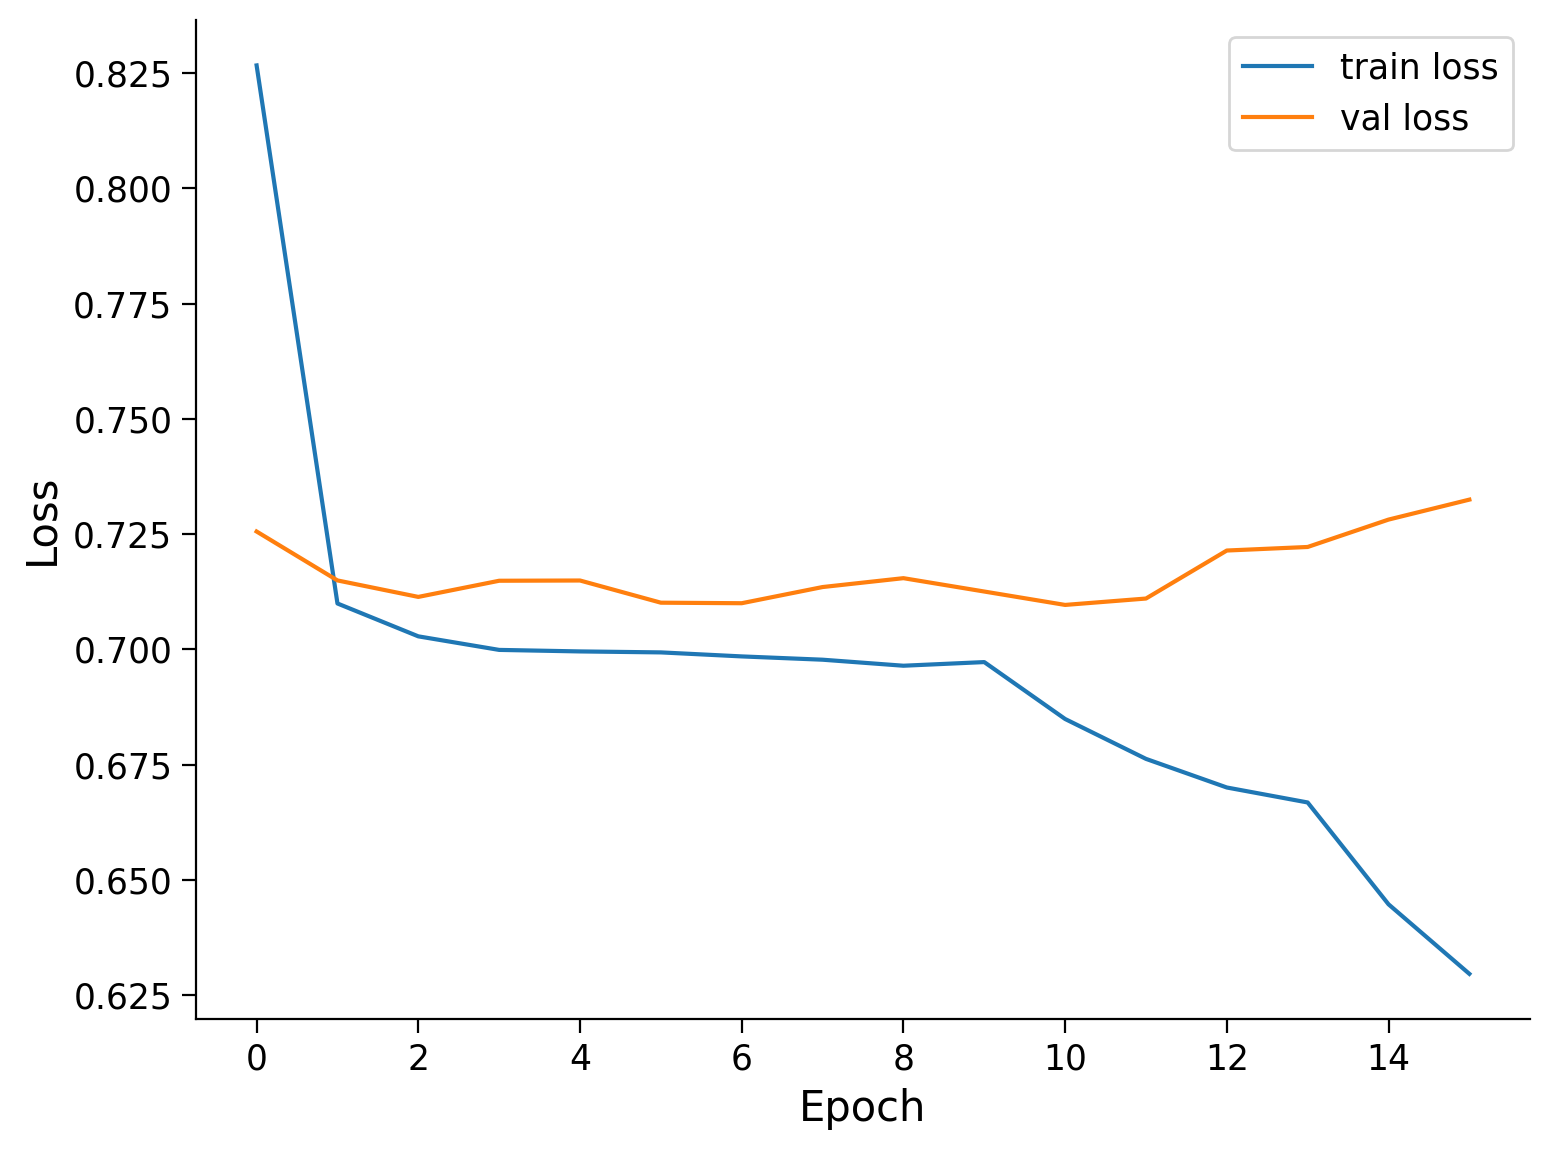

Epoch 1/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - accuracy: 0.5413 - loss: 0.9495 - val_accuracy: 0.5331 - val_loss: 0.7263 - learning_rate: 0.0010
Epoch 2/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.5686 - loss: 0.7099 - val_accuracy: 0.5528 - val_loss: 0.7175 - learning_rate: 0.0010
Epoch 3/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.5809 - loss: 0.7014 - val_accuracy: 0.5563 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 4/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.5842 - loss: 0.6975 - val_accuracy: 0.5549 - val_loss: 0.7095 - learning_rate: 0.0010
Epoch 5/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.5783 - loss: 0.6967 - val_accuracy: 0.5600 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 6/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.5850 - loss: 0.6933 - val_accuracy: 0.5482 - val_loss: 0.7122 - learning_rate: 0.0010
Epoch 7/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step - accura

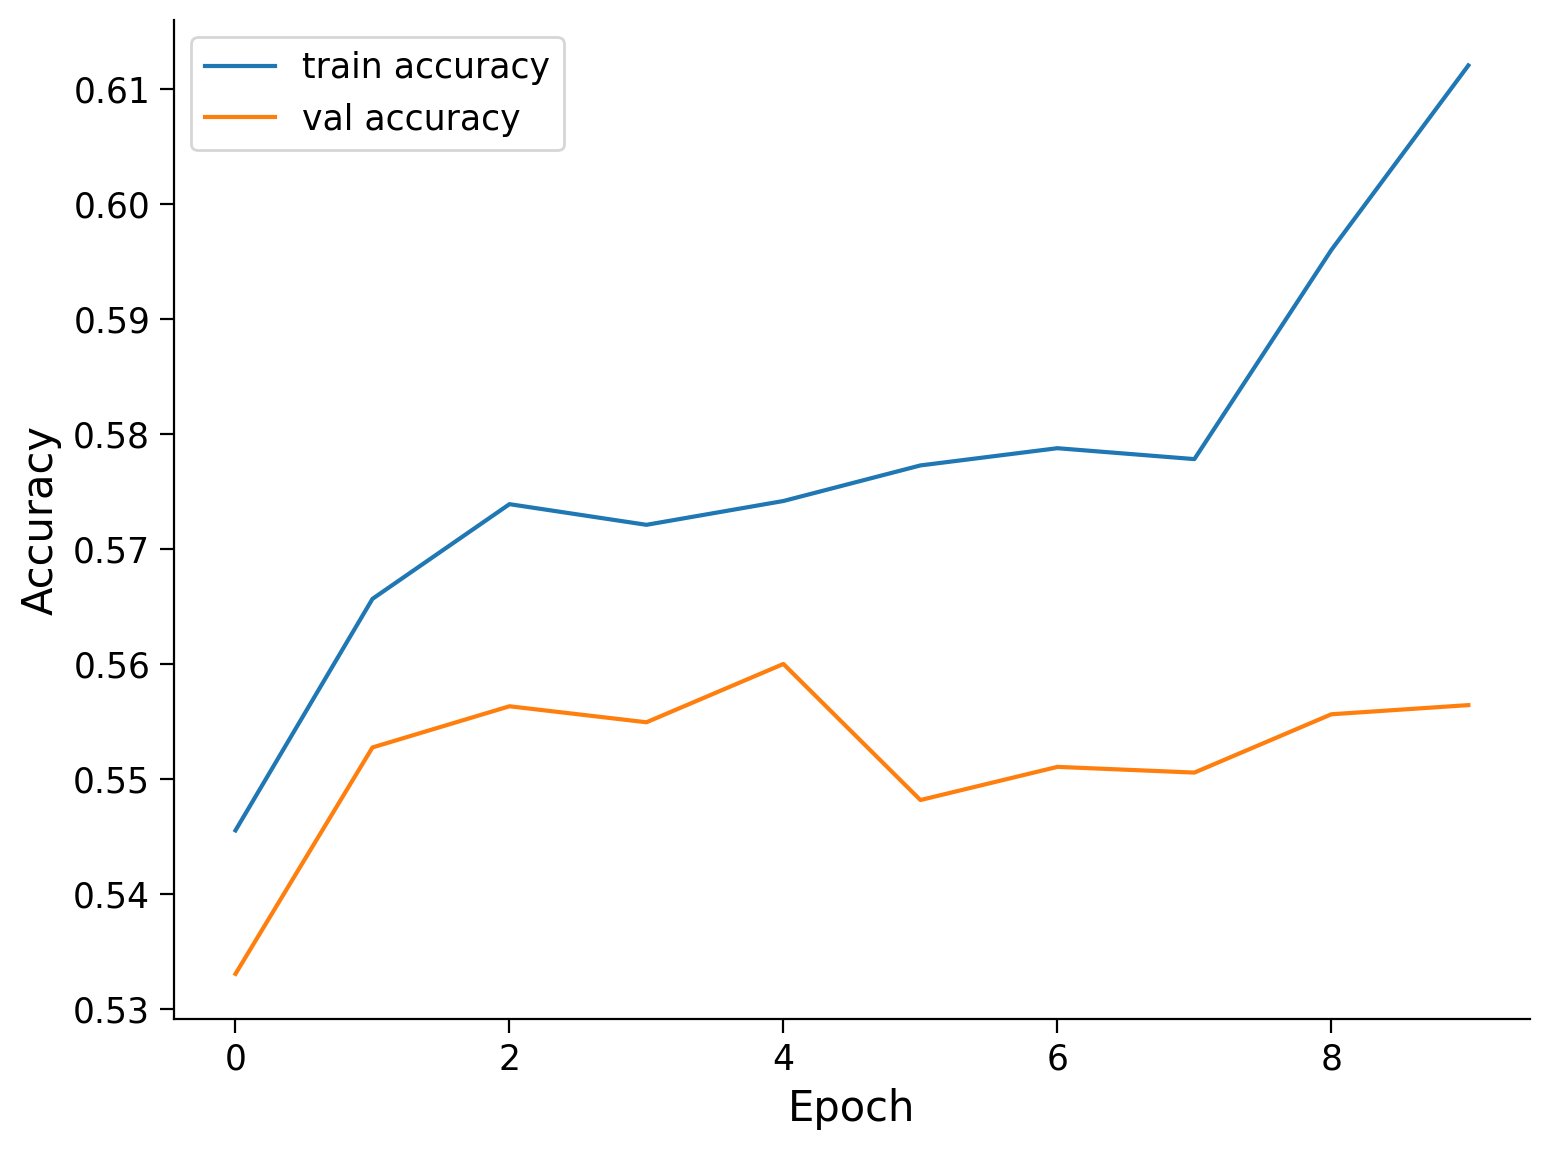

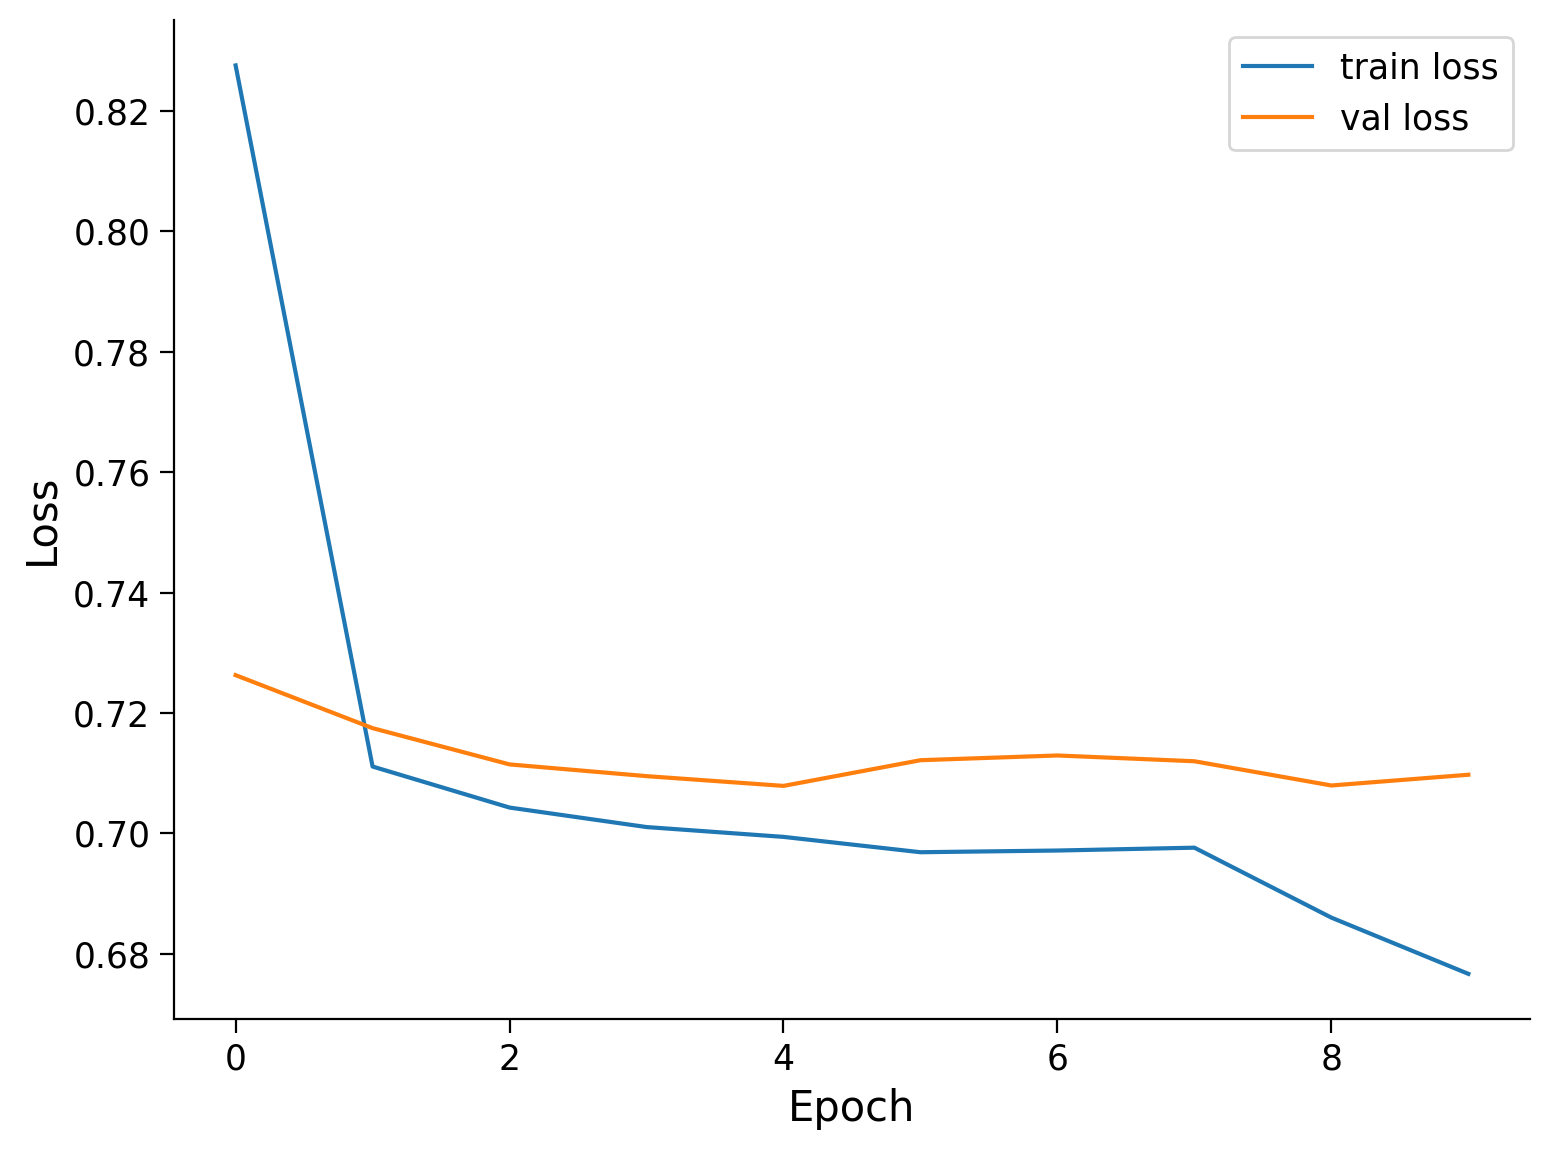

Epoch 1/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.5371 - loss: 0.9465 - val_accuracy: 0.5521 - val_loss: 0.7202 - learning_rate: 0.0010
Epoch 2/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.5722 - loss: 0.7075 - val_accuracy: 0.5572 - val_loss: 0.7106 - learning_rate: 0.0010
Epoch 3/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.5764 - loss: 0.7000 - val_accuracy: 0.5505 - val_loss: 0.7124 - learning_rate: 0.0010
Epoch 4/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.5751 - loss: 0.6996 - val_accuracy: 0.5531 - val_loss: 0.7063 - learning_rate: 0.0010
Epoch 5/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.5817 - loss: 0.6950 - val_accuracy: 0.5505 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 6/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.5751 - loss: 0.6953 - val_accuracy: 0.5553 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 7/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accura

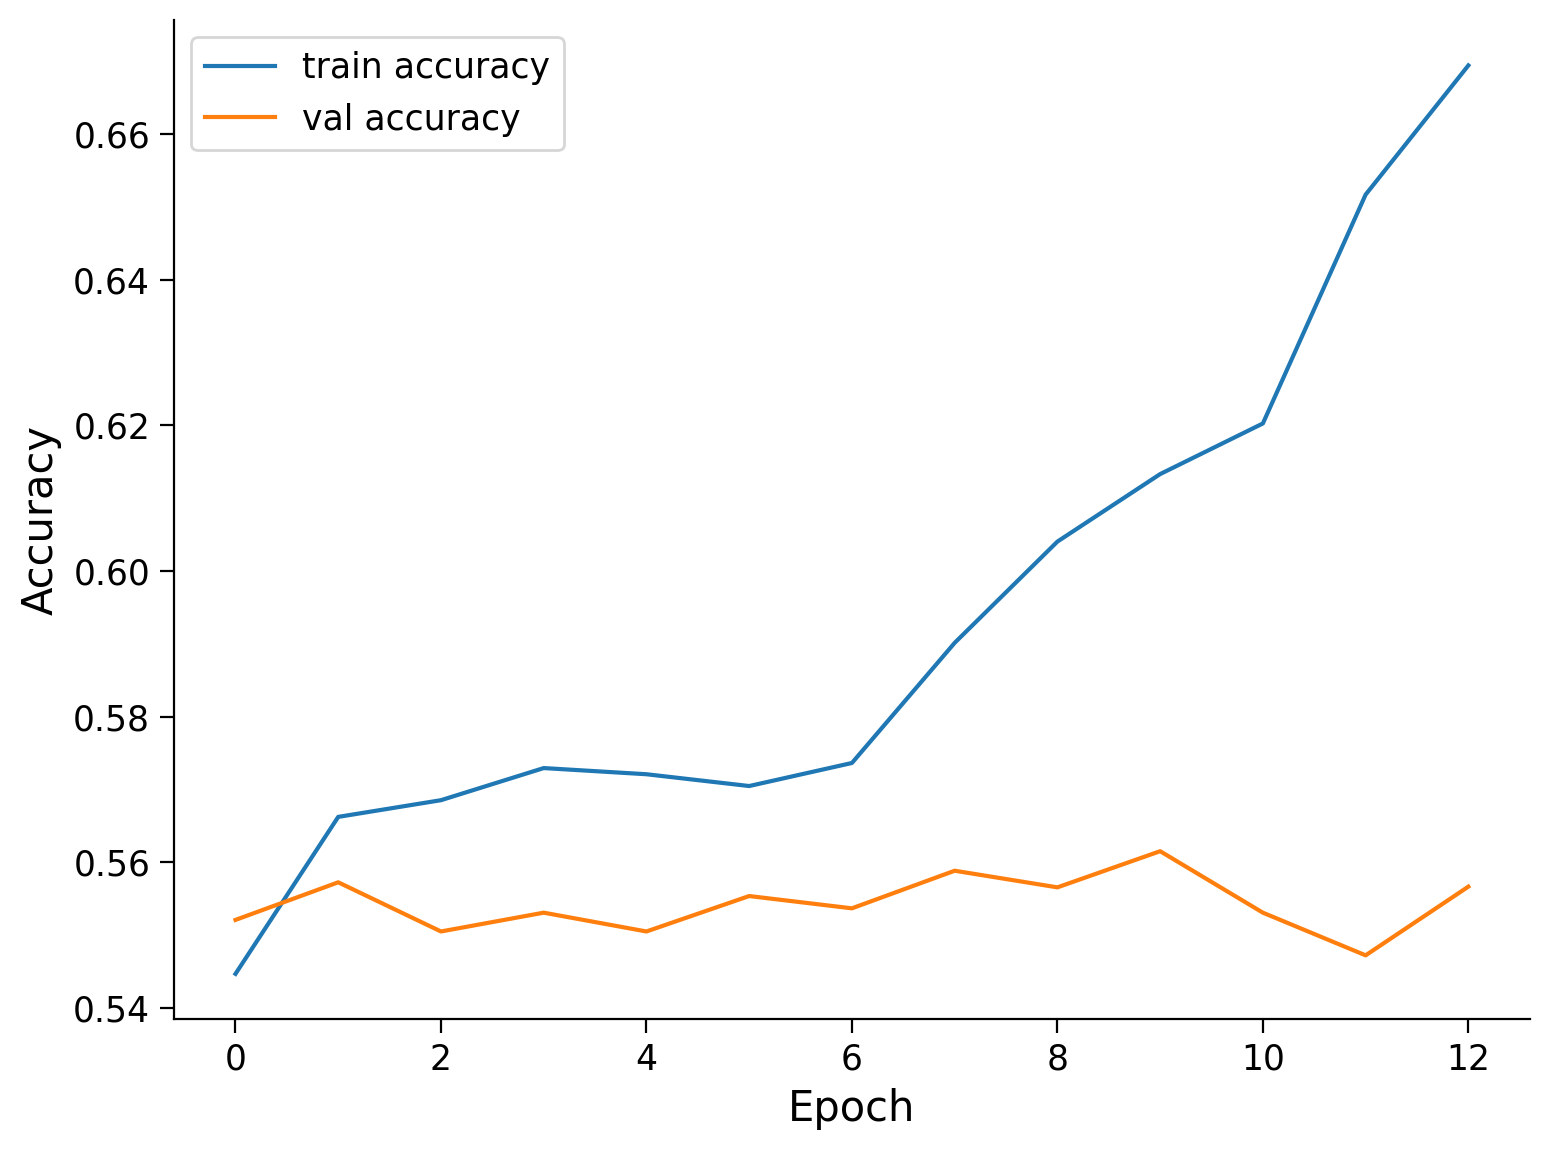

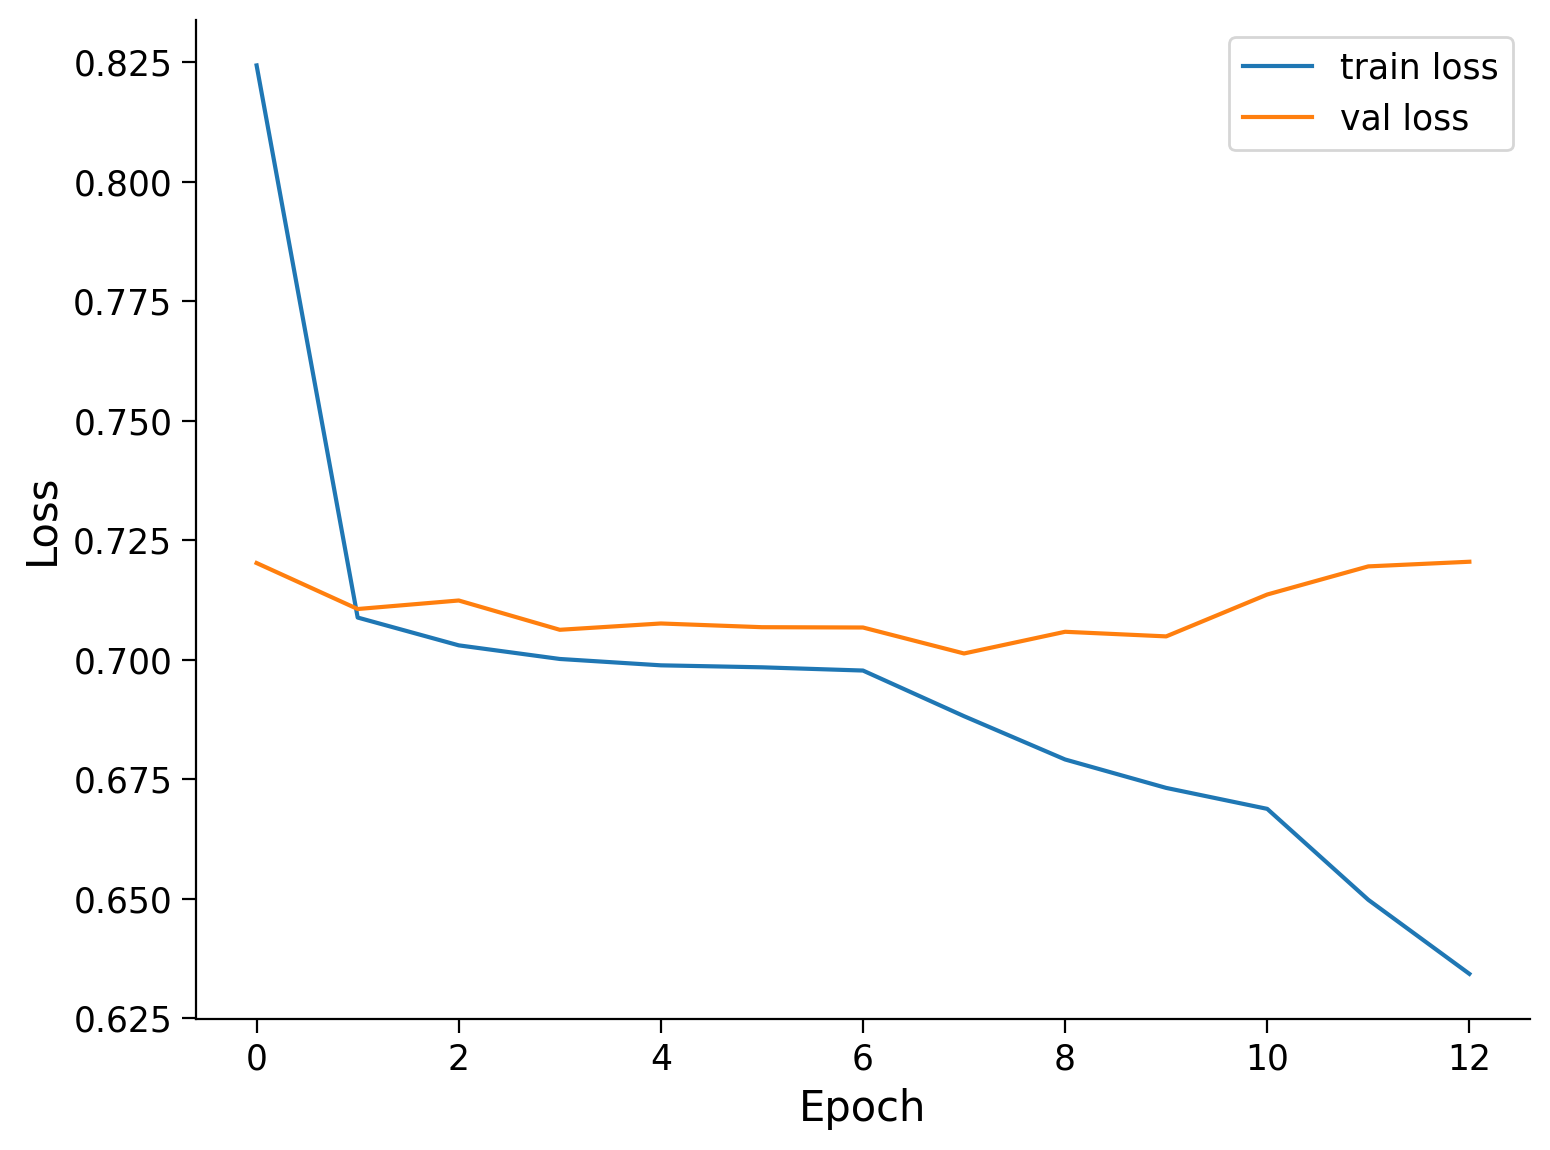

Epoch 1/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.5318 - loss: 0.9484 - val_accuracy: 0.5446 - val_loss: 0.7226 - learning_rate: 0.0010
Epoch 2/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.5731 - loss: 0.7087 - val_accuracy: 0.5567 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 3/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.5757 - loss: 0.7004 - val_accuracy: 0.5551 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 4/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.5744 - loss: 0.6993 - val_accuracy: 0.5523 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 5/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.5797 - loss: 0.6954 - val_accuracy: 0.5602 - val_loss: 0.7062 - learning_rate: 0.0010
  1/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5312 - loss: 0.7244

KeyboardInterrupt: 

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

# Parameters
window_length = int(15 / 0.72)  # 15 seconds / 0.72 TR
step_size = int(3 / 0.72)       # 3 seconds / 0.72 TR

print(f"Expected window length: {window_length}")

# Function to create sliding windows
def create_windows(data, window_length, step_size):
    windows = []
    for i in range(0, data.shape[1] - window_length + 1, step_size):
        windows.append(data[:, i:i + window_length])
    return np.array(windows)

# Example subject IDs, replace with your actual data
subject_ids_two_back = np.arange(len(two_back_fpn))
subject_ids_no_back = np.arange(len(no_back_fpn)) + len(subject_ids_two_back)

# Print initial data shapes
print(f"two_back_fpn shape: {two_back_fpn[0].shape}")
print(f"no_back_fpn shape: {no_back_fpn[0].shape}")

# Create windows for both conditions and collect subject IDs
two_back_windows = []
no_back_windows = []
subjects_two_back = []
subjects_no_back = []

for idx, subject_data in enumerate(two_back_fpn):
    windows = create_windows(subject_data, window_length, step_size)
    print(f"Generated two_back_windows shape: {windows.shape}")
    two_back_windows.append(windows)
    subjects_two_back.extend([subject_ids_two_back[idx]] * len(windows))

for idx, subject_data in enumerate(no_back_fpn):
    windows = create_windows(subject_data, window_length, step_size)
    # print(f"Generated no_back_windows shape: {windows.shape}")
    no_back_windows.append(windows)
    subjects_no_back.extend([subject_ids_no_back[idx]] * len(windows))

# Convert lists to arrays and concatenate
two_back_windows = np.concatenate(two_back_windows, axis=0)
no_back_windows = np.concatenate(no_back_windows, axis=0)
subjects_two_back = np.array(subjects_two_back)
subjects_no_back = np.array(subjects_no_back)

# Check shapes
print(f"two_back_windows shape after concat: {two_back_windows.shape}")
print(f"no_back_windows shape after concat: {no_back_windows.shape}")
print(f"subjects_two_back shape after concat: {subjects_two_back.shape}")
print(f"subjects_no_back shape after concat: {subjects_no_back.shape}")

# Create labels
labels_two_back = np.ones((two_back_windows.shape[0], 1))
labels_no_back = np.zeros((no_back_windows.shape[0], 1))

# Combine data, labels, and subjects
X = np.concatenate((two_back_windows, no_back_windows), axis=0)
y = np.concatenate((labels_two_back, labels_no_back), axis=0)
subjects = np.concatenate((subjects_two_back, subjects_no_back), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
subjects = subjects[indices]

# # Verify the number of features
# assert X.shape[2] == 20, "Mismatch in the number of features. Expected 20, got {}".format(X.shape[2])

# Define the model
def create_model(input_shape):
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    encoder = LSTM(256, return_state=True, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Add batch normalization and dropout to encoder
    encoder_outputs = BatchNormalization()(encoder_outputs)
    encoder_outputs = Dropout(0.3)(encoder_outputs)

    # Decoder
    decoder_inputs = Input(shape=input_shape)
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(input_shape[1], activation='sigmoid')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Add batch normalization and dropout to decoder
    decoder_outputs = BatchNormalization()(decoder_outputs)
    decoder_outputs = Dropout(0.3)(decoder_outputs)

    # Classifier
    classifier_dense = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    classifier_output = classifier_dense(state_h)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], classifier_output)

    # Compile the model with RMSprop optimizer
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Use GroupKFold for cross-validation
gkf = GroupKFold(n_splits=5)

for train_index, test_index in gkf.split(X, y, groups=subjects):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train the model
    model = create_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(
        [X_train, X_train], y_train, 
        epochs=20, 
        batch_size=32, 
        validation_data=([X_test, X_test], y_test), 
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate([X_test, X_test], y_test)
    print(f"Fold Test Accuracy: {accuracy}")

    # Plot training history
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
